# experiment with SAE
https://transformer-circuits.pub/2023/monosemantic-features

In [35]:
import os
import torch as t
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import transformer_lens
from tqdm.notebook import tqdm
import wandb
from functools import lru_cache
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
device = 'cuda' if t.cuda.is_available() else ('mps' if t.backends.mps.is_available() else 'cpu')
device

'cuda'

In [6]:
class CFG():
    sae_layer = 0
    n_in = 3072
    n_hidden = n_in * 8
    batch_size = 16
    max_context = 600

cfg = CFG()

In [7]:
gpt2 = transformer_lens.HookedTransformer.from_pretrained("gpt2-small")
gpt2_dataset = gpt2.load_sample_training_dataset()

Loaded pretrained model gpt2-small into HookedTransformer


In [11]:
@t.no_grad()
def scope():
    logits, cache = gpt2.run_with_cache("a black cat")
    print(cache)

scope()

ActivationCache with keys ['hook_embed', 'hook_pos_embed', 'blocks.0.hook_resid_pre', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.ln2.hook_scale', 'blocks.0.ln2.hook_normalized', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.ln1.hook_scale', 'blocks.1.ln1.hook_normalized', 'blocks.1.attn.hook_q', 'blocks.1.attn.hook_k', 'blocks.1.attn.hook_v', 'blocks.1.attn.hook_attn_scores', 'blocks.1.attn.hook_pattern', 'blocks.1.attn.hook_z', 'blocks.1.hook_attn_out', 'blocks.1.hook_resid_mid', 'blocks.1.ln2.hook_scale', 'blocks.1.ln2.hook_normalized', 'blocks.1.mlp.hook_pre', 'blocks.1.mlp.hook_post', 'blocks.1.hook_mlp_out', 'blocks.1.hook_resid_post', 'blocks.2.hook_re

In [12]:
class Dataset(Dataset):
    def __init__(self, gpt2, gpt2_dataset):
        self.gpt2 = gpt2
        self.gpt2_dataset = gpt2_dataset

    def __len__(self):
        return len(self.gpt2_dataset)

    # @lru_cache(maxsize=None)
    def __getitem__(self, idx):
        sentence = self.gpt2_dataset[idx]
        tokens = self.gpt2.to_tokens(sentence['text'], padding_side="right")
        _, activations = self.gpt2.run_with_cache(tokens)
        return activations['mlp_out', cfg.sae_layer]
    
dataset = Dataset(gpt2, gpt2_dataset)
train_dataloader = DataLoader(dataset, batch_size=cfg.batch_size, shuffle=True)

In [ ]:
# def hook_mlp_out(gpt2):
#     filter_mlp_out = lambda name: ("blocks.0.hook_mlp_out" == name)
#     gpt2.reset_hooks()
#     cache = {}
#     def forward_cache_hook(act, hook):
#         cache[hook.name] = act.detach()
#     gpt2.add_hook(filter_mlp_out, forward_cache_hook, "fwd")
#     return cache

# cache = hook_mlp_out(gpt2)
# gpt2(gpt2_dataset[:10]['text'])
# cache['blocks.0.hook_mlp_out'].shape

In [ ]:
def create_dataset(batch_size=32, write_after=1000):
    filter_mlp_out = lambda name: ("blocks.0.mlp.hook_post" == name)
    gpt2.reset_hooks()
    cache = {}
    def forward_cache_hook(act, hook):
        cache[hook.name] = act.detach()
        raise Exception("end execution")
    gpt2.add_hook(filter_mlp_out, forward_cache_hook, "fwd")

    output = []
    with t.no_grad():
        for slice in tqdm(range(0, len(gpt2_dataset), batch_size)):
            print("looking at slice", slice)
            if slice % write_after < batch_size and slice > 0:
                print("writing to disk")
                t.save(t.cat(output, dim=0), f"activations_{slice}.pt")
                output = []

            if slice+batch_size >= len(gpt2_dataset):
                sliced_dataset = gpt2_dataset[slice:]['text']
            else:
                sliced_dataset = gpt2_dataset[slice:slice+batch_size]['text']

            try:
                gpt2(sliced_dataset)
            except Exception:
                pass

            activations_for_batch = cache['blocks.0.mlp.hook_post']
            output.append(activations_for_batch)
    # print(f"{output=}")
    t.save(t.cat(output, dim=0), f"activations_final.pt")

# create_dataset(write_after=100)

In [16]:
files = [fname for fname in os.listdir('./') if 'new_activations' in fname]
activation_tensors = [t.load(fname, mmap=True) for fname in files[:5]]

In [18]:
class Dataset(Dataset):
    def __init__(self, activation_tensors):
        self.activation_tensors = activation_tensors

    def __len__(self):
        return len(self.activation_tensors)

    def __getitem__(self, idx):
        return self.activation_tensors[idx]

concat = t.utils.data.ConcatDataset([Dataset(act) for act in activation_tensors]) 
train_dataloader = DataLoader(concat, batch_size=cfg.batch_size, shuffle=False)

def scope():
    for batch in train_dataloader:
        print(batch[0].shape) # should be (64, 1024, 768)
        break
scope()

AssertionError: datasets should not be an empty iterable

## model

In [27]:
class SAE(nn.Module):
    def __init__(self, n_in, n_hidden):
        super(SAE, self).__init__()
        self.b_a = nn.Parameter(t.zeros(n_in))
        self.b_d = nn.Parameter(t.zeros(n_in))
        self.b_e = nn.Parameter(t.zeros(n_hidden))

        self.W_e = nn.Linear(n_in, n_hidden, bias=False)
        self.W_d = nn.Linear(n_hidden, n_in, bias=False)

    def forward(self, act):
        x = act + self.b_a
        x = self.W_e(x) + self.b_e
        x = F.relu(x)
        hidden_activations = x
        x = self.W_d(x) + self.b_d
        return x, hidden_activations

## train

In [ ]:
model = SAE(n_in=cfg.n_in, n_hidden=cfg.n_hidden).to(device)
opt = t.optim.Adam(model.parameters(), lr=1e-3)
def train(model, opt, dataloader, epochs=100, l1_factor=0.1, wnb=True):
    if wnb:
        wandb.init(project='SAE')

    for epoch in tqdm(range(epochs)):
        for batch in tqdm(dataloader):
            batch = batch[0].to(device)
            logits, hidden_activations = model(batch)
            reconstruction_loss = F.mse_loss(logits, batch)
            sparsity_loss = hidden_activations.abs().mean()
            loss = reconstruction_loss + l1_factor * sparsity_loss
            if wnb:
                wandb.log({"reconstruction_loss": reconstruction_loss.item()})
                wandb.log({"sparsity_loss": sparsity_loss.item()})
                wandb.log({"loss": loss.item()})
            opt.zero_grad()
            loss.backward()
            opt.step()

# train(model, opt, train_dataloader)

In [33]:
# t.save(model.state_dict(), 'model_intermediate.pt')
# model.load_state_dict(t.load('model_intermediate.pt', map_location=device))

## utils

In [265]:
@t.no_grad()
def autoregressively_generate(gpt2, input, n_tokens=8, print_step=False, print_final=True):
    for i in range(n_tokens):
        logits = gpt2(input)
        most_probable_token = logits[0, -1].argmax().item()
        output = gpt2.to_single_str_token(most_probable_token)
        input += output
        if print_step: print(input)
    if print_final: print(input)
    return input

input = "The heart of a blue whale is so"
autoregressively_generate(gpt2, input)
autoregressively_generate(gpt2, input.upper())

The heart of a blue whale is so MUCH MORE THAN THE BODY.
THE HEART OF A BLUE WHALE IS SO MUCH MORE THAN A PENNY


'THE HEART OF A BLUE WHALE IS SO MUCH MORE THAN A PENNY'

In [ ]:
def add_sae_hook(gpt2=gpt2, sae=model):
    filter_mlp_out = lambda name: ("blocks.0.mlp.hook_post" == name)
    gpt2.reset_hooks()
    cache = {}
    def forward_cache_hook(act, hook):
        with t.no_grad():
            logits, hidden_activations = sae(act)
            cache[hook.name] = hidden_activations.detach()
            return logits

    gpt2.add_hook(filter_mlp_out, forward_cache_hook, "fwd")
    return cache

## experiments

### where is uppercase

In [109]:
input = 'the black cat was eating'.upper()
input = 'once uppon a time in a'.upper()
input = 'hello, my name is regis, how are'.upper()

gpt2.reset_hooks()
# names_filter=
logits, cache = gpt2.run_with_cache(input)

point = cache['blocks.0.hook_mlp_out']
# point = cache['blocks.0.hook_resid_post']
# point = cache['ln_final.hook_normalized']
point = cache['blocks.0.hook_attn_out']
point = cache['blocks.0.hook_resid_mid']

point = cache['blocks.0.hook_resid_pre'] # earliest uppercase
point = cache['blocks.7.hook_mlp_out'] # earliest MLP that is upper? sometime 6 ?


tokens = gpt2.unembed(gpt2.ln_final(point)).softmax(dim=-1).argmax(dim=-1)
print(gpt2.to_string(tokens[0, -1]))

# autoregressively_generate(gpt2, input)
# autoregressively_generate(gpt2, input.upper())

 YOU


gpt2_next_token=[' led', ' I', ' and', ' and', ' time', ' Health', ' is', ' What', ' and', ' the', ' a', ' World', ' to', ' the', ' be', ' to', ' for', ' and', ' the', ' the']
mlp_outs=['um', 'ity', 'alia', 'med', 'lying', 'boy', 'um', 'ler', 'lets', 'ap', 'ae', 'ap', 'ae', 'ae', 'adem', 'ae', 'oe', 'ae', 'ler', 'unci']
max activated token:  tensor(401)


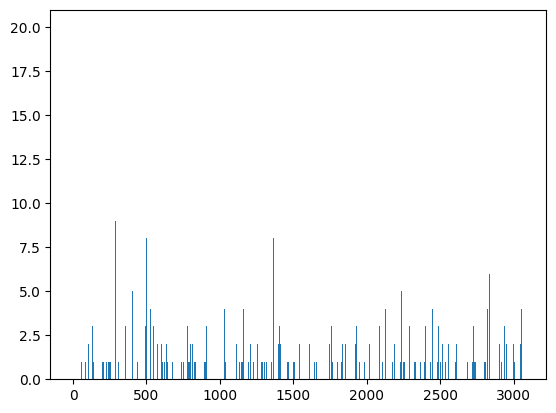

In [250]:
def scope(layer='blocks.7.mlp.hook_post'):
    sentences = [
        "THIS IS THE BEGINNING OF A GREAT ADVENTURE, WHICH THEN",
        "EVERY MORNING I WAKE UP AND START MY DAY, AND",
        "PEOPLE OFTEN WONDER ABOUT THE MEANING OF LIFE, BUT SELDOM",
        "COMPUTERS HAVE BECOME ESSENTIAL TO OUR DAILY LIVES, MAKING WORK",
        "READING BOOKS CAN SIGNIFICANTLY IMPROVE YOUR MIND AND, OVER",
        "HEALTHY EATING IS NOT JUST ABOUT WEIGHT, IT'S ABOUT",
        "MUSIC HAS THE POWER TO HEAL AND INSPIRE PEOPLE, WHICH",
        "SCIENCE CONTINUALLY PUSHES THE BOUNDARIES OF WHAT WE KNOW, AND",
        "LEARNING A NEW LANGUAGE OPENS UP A WORLD OF OPPORTUNITIES,",
        "TRAVELING TO NEW PLACES CAN BROADEN YOUR PERSPECTIVE ON, AND",
        "VIDEO GAMES OFFER A WAY TO ESCAPE REALITY, BUT ALSO",
        "COFFEE IN THE MORNING CAN SET THE TONE FOR THE",
        "FRIENDSHIPS ARE BUILT ON TRUST AND MUTUAL RESPECT, WHICH GROWS",
        "ART PROVIDES A MIRROR TO SOCIETY, SHOWCASING CULTURAL TRENDS AND",
        "EDUCATION IS KEY TO UNLOCKING POTENTIAL AND EXPANDING, THEREFORE ALWAYS",
        "THE INTERNET CONNECTS PEOPLE GLOBALLY, YET ALSO POSES SIGNIFICANT CHALLENGES",
        "PHYSICAL ACTIVITY IS CRUCIAL FOR MAINTAINING HEALTH AND BOOSTING, ESPECIALLY",
        "ENVIRONMENTAL CONSERVATION IS ESSENTIAL FOR SUSTAINABILITY AND FUTURE GENERATIONS,",
        "INVESTING WISELY REQUIRES UNDERSTANDING RISK AND REWARD, WHICH IS NOT",
        "LEADERSHIP DEMANDS RESPONSIBILITY, VISION, AND THE ABILITY TO NAVIGATE, UNDER",
    ]

    gpt2.reset_hooks()
    filter_mlp_out = lambda name: (layer == name)
    cache = {}
    def forward_cache_hook(act, hook):
        with t.no_grad():
            cache[hook.name] = act.clone().detach()
            # act[:, :, 623] *= 0
            act[:, :, 401] = -10.
            # act[:, :, 401] = 10.
            # act[:, :, 2367] *= 0
            return act
    gpt2.add_hook(filter_mlp_out, forward_cache_hook, "fwd")

    filter_mlp_out2 = lambda name: ('blocks.7.hook_mlp_out' == name)
    def forward_cache_hook2(act, hook):
        with t.no_grad():
            cache[hook.name] = act.clone().detach()
    gpt2.add_hook(filter_mlp_out2, forward_cache_hook2, "fwd")

    most_frequent_top100_neurons = []
    mlp_outs = []
    gpt2_next_token = []

    for sentence in sentences:
        # sentence = sentence.lower()
        # logits, cache = gpt2.run_with_cache(sentence, names_filter=[layer])
        logits = gpt2(sentence)
        # print('next_token=', [gpt2.to_single_str_token(x.item()) for x in logits.argmax(-1)[:, -1]])
        gpt2_next_token.append(gpt2.to_single_str_token(logits.argmax(-1)[:, -1].item()))

        last_tokens = cache[layer][:, -1]
        mlp_out = cache['blocks.7.hook_mlp_out']
        token = gpt2.unembed(gpt2.ln_final(mlp_out)).softmax(dim=-1).argmax(dim=-1)
        mlp_outs.append(gpt2.to_single_str_token(token[:, -1].item()))
        # print('mlp_out=', gpt2.to_string(token[:, -1]))

        top_neurons_val, top_neurons_idx = last_tokens.topk(dim=-1, k=100)
        # print(f'{top_neurons_idx.shape=}')
        most_frequent_top100_neurons.append(top_neurons_idx.view(-1))
        # print(f'{most_frequent_top100_neurons.shape=}')
    print(f'{gpt2_next_token=}')
    print(f'{mlp_outs=}')
    bins = t.cat(most_frequent_top100_neurons, dim=0).bincount().cpu()
    print('max activated token: ', bins.argmax()) # 623
    plt.bar(t.arange(len(bins)), bins)

scope()

In [276]:
def hook_401(val):
    gpt2.reset_hooks()
    hk_filter = lambda name: ('blocks.7.mlp.hook_post' == name)
    def hk(act, hook):
        with t.no_grad():
            act[:, :, 401] = val
            # act[:, :, 401] = val
            # print('messing up')
            return act
    gpt2.add_hook(hk_filter, hk, "fwd")

sentence = 'The heart of a blue whale is so'
# sentence = 'THIS IS THE BEGINNING OF A GREAT ADVENTURE, WHICH THEN'
print('GPT2 base\n---')
gpt2.reset_hooks()
autoregressively_generate(gpt2, sentence.lower())
autoregressively_generate(gpt2, sentence.upper())

print('\nlayer=7 neuron=401 to 0\n---')
hook_401(0)
autoregressively_generate(gpt2, sentence.lower())
autoregressively_generate(gpt2, sentence.upper())

print('\nlayer=7 neuron=401 to 10\n---')
hook_401(20)
autoregressively_generate(gpt2, sentence.lower())
autoregressively_generate(gpt2, sentence.upper())

pass


GPT2 base
---
the heart of a blue whale is so small that it can't even be seen
THE HEART OF A BLUE WHALE IS SO POWERFUL, THAT IT CAN BE T

layer=7 neuron=401 to 0
---
the heart of a blue whale is so small that it can't even be seen
THE HEART OF A BLUE WHALE IS SO FAST, it's hard to believe

layer=7 neuron=401 to 10
---
the heart of a blue whale is so MUCH MORE THAN THE BODY OF
THE HEART OF A BLUE WHALE IS SO MUCH MORE THAN A PENNY


In [275]:
gpt2.reset_hooks()
sentence = 'The basketball player isn\'t'
sentence = 'THE BASKETBALL PLAYER ISN\'T'
autoregressively_generate(gpt2, sentence)

THE BASKETBALL PLAYER ISN'T A GOOD PLAYER.





"THE BASKETBALL PLAYER ISN'T A GOOD PLAYER.\n\n\n"

### fact vs question

In [ ]:
fact_question_dataset = [
    {
        "fact": "The heart of a blue whale is so big, a human could swim through the arteries of its heart.",
        "question": "Is it true that a human could swim through the arteries of a blue whale's heart?"
    },
    {
        "fact": "Sloths can hold their breath for up to 40",
        "question": "Can sloths really hold their breath for up to 40 minutes?"
    },
    {
        "fact": "A snail can sleep for up to three years.",
        "question": "Can a snail sleep for up to three years?"
    },
    {
        "fact": "Penguins have knees.",
        "question": "Do penguins really have knees?"
    },
    {
        "fact": "The male emperor penguin protects the eggs from the cold.",
        "question": "Is it the male emperor penguin that protects the eggs from the cold?"
    },
    {
        "fact": "The largest land animal is the African elephant.",
        "question": "Is the African elephant the largest land animal?"
    },
    {
        "fact": "Kangaroos use their tails for balance.",
        "question": "Do kangaroos use their tails for balance?"
    },
    {
        "fact": "A group of flamingos is called a 'flamboyance.'",
        "question": "Is a group of flamingos called a 'flamboyance'?"
    },
    {
        "fact": "Rabbits and hares are different species.",
        "question": "Are rabbits and hares different species?"
    },
    {
        "fact": "Cows have four stomachs.",
        "question": "Do cows have four stomachs?"
    }
]


### uppercase
get top activations for uppercase vs lowercase

In [ ]:
lower_caches = []
upper_caches = []
for pair in fact_question_dataset:
    lower = pair["fact"]
    upper = lower.upper()
    gpt2(lower)
    lower_caches.append(cache["blocks.0.mlp.hook_post"])
    gpt2(upper)
    upper_caches.append(cache["blocks.0.mlp.hook_post"])

In [ ]:
lower_caches[0].shape

In [ ]:
max_lower = t.stack([x.amax(dim=(0,1)) for x in lower_caches]).amax(0)
print(max_lower)
min_upper = t.stack([x.amin(dim=(0,1)) for x in upper_caches]).amin(0)
print(min_upper.amax())
neuron_idx = (min_upper - max_lower).argmax()
print(min_upper[neuron_idx])
print(max_lower[neuron_idx]) 

In [ ]:
frequency_neuron_counter = {}
flat_count = []
for l in lower_caches:
    v, i= l.topk(100, dim=2)
    flat_count.append(i.view(-1))

bincount = t.cat(flat_count, dim=0).bincount().cpu()
print(bincount.topk(100))

torch.return_types.topk(
values=tensor([111, 110, 110, 110, 106, 105, 104, 102, 102, 102, 102, 102, 102, 102,
        102, 102, 102, 102, 102, 102, 102, 102, 102, 101, 101, 101, 101, 101,
        101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101,
        101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101,
        101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101,
        101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101,
        100, 100, 100, 100, 100,  98,  97,  97,  97,  97,  94,  92,  91,  88,
         71,  63]),
indices=tensor([15663,  1391, 17581,  7686, 23529,  6271,   347,     8,     3,    11,
         4037,     2,     1,     6,    10,     0,    12,     4,    22,    13,
            9,     5,     7,    59,    29,    61,    57,    56,    27,    55,
           53,    25,    51,    49,    48,    23,    47,    45,    21,    43,
           44,    46,    20,    41,    24,    50,    52,    26,    54,    42,
    

In [ ]:
frequency_neuron_counter = {}
flat_count = []
for l in upper_caches:
    v, i= l.topk(100, dim=2)
    flat_count.append(i.view(-1))
bincount = t.cat(flat_count, dim=0).bincount().cpu()
print(bincount.topk(100))

torch.return_types.topk(
values=tensor([166, 163, 161, 161, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160,
        160, 160, 160, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159,
        159, 159, 159, 159, 159, 159, 159, 158, 158, 158, 158, 158, 158, 158,
        158, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157,
        157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 156, 155, 155,
        155, 155, 155, 155, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154,
        154, 152, 151, 151, 150, 150, 149, 148, 147, 145, 140, 134, 129, 124,
        116,  95]),
indices=tensor([15663, 17581,  1391,  7686,    12,     5,     9,     6,     4,     2,
           10,     3,     8,    11,     7,     1,     0,    28,    27,    25,
           13,    24,    23,    26,    14,    21, 23529,    22,    19,    18,
           17,    29,    16,    15,    20,    30,    37,    36,    35,    34,
           33,    32,    31,    60,    59,    57,    56,    55,    53,    54,
    

In [ ]:
output = gpt2(fact_question_dataset[0]['fact']) 
most_probable_token = t.argmax(output[0, -1]).item()
gpt2.to_single_str_token(most_probable_token)

In [ ]:
def monitor_neuron(neuron_idx, autoencoder, model, dataset): # dataset is a list of sentences
   filter_mlp_out = lambda name: ("blocks.0.mlp.hook_post" == name)
   gpt2.reset_hooks()
   cache = {}
   def forward_cache_hook(act, hook):
      cache[hook.name] = act.detach()
      raise Exception("end execution")
   gpt2.add_hook(filter_mlp_out, forward_cache_hook, "fwd")

   try:
      gpt2(dataset)
   except Exception:
      pass

   activations_for_batch = cache['blocks.0.mlp.hook_post'] # [batch, ctx, d_in]
   _, sae_activations = autoencoder(activations_for_batch)

   activations_per_sentence_and_word = {}

   print(sae_activations.shape)
   tokenized = gpt2.to_tokens(dataset)
   for sentence_idx, sentence in enumerate(dataset):
      sentence_tokens = tokenized[sentence_idx]
      for token_idx, token in enumerate(sentence_tokens):
         activations_per_sentence_and_word[(sentence_idx, token_idx)] = sae_activations[sentence_idx, token_idx, neuron_idx]
   return activations_per_sentence_and_word

# neuron_0 = monitor_neuron(0, autoencoder=model, model=gpt2, dataset=gpt2_dataset[:32]['text'])

In [ ]:
# all_neuron_activations = [
#     sorted(
#         monitor_neuron(i, model, gpt2, gpt2_dataset[:32]['text']).items(),
#         key=lambda x: x[1],
#         reverse=True
#     )
# for i in [14000]]

torch.Size([32, 1024, 24576])


In [ ]:
# tokenized = gpt2.to_tokens(gpt2_dataset[:32]['text'])
# tokens_which_activated_neuron_23 = all_neuron_activations[0][:100]
# # print(tokens_which_activated_neuron_23[0])
# tokenized_sentences = [
#     tokenized[sentence_idx][max(word_idx - 20, 0):word_idx + 1] for (sentence_idx, word_idx), _ in tokens_which_activated_neuron_23
# ]
# untokenized_sentences = [
#     gpt2.to_string(tokenized_sentence) for tokenized_sentence in tokenized_sentences
# ]
# from pprint import pprint
# pprint(untokenized_sentences)

['<|endoftext|>',
 '<|endoftext|>A',
 '<|endoftext|>A magazine',
 '<|endoftext|>A magazine supplement',
 '<|endoftext|>A magazine supplement with',
 '<|endoftext|>A magazine supplement with an',
 '<|endoftext|>A magazine supplement with an image',
 '<|endoftext|>A magazine supplement with an image of',
 '<|endoftext|>A magazine supplement with an image of Adolf',
 '<|endoftext|>A magazine supplement with an image of Adolf Hitler',
 '<|endoftext|>A magazine supplement with an image of Adolf Hitler and',
 '<|endoftext|>A magazine supplement with an image of Adolf Hitler and the',
 '<|endoftext|>A magazine supplement with an image of Adolf Hitler and the '
 'title',
 '<|endoftext|>A magazine supplement with an image of Adolf Hitler and the '
 "title '",
 '<|endoftext|>A magazine supplement with an image of Adolf Hitler and the '
 "title 'The",
 '<|endoftext|>A magazine supplement with an image of Adolf Hitler and the '
 "title 'The Un",
 '<|endoftext|>A magazine supplement with an image o

In [84]:
filter_mlp_out = lambda name: ("blocks.0.mlp.hook_post" == name)
gpt2.reset_hooks()
cache = {}
def forward_cache_hook(act, hook):
    cache[hook.name] = act.detach()
    raise Exception("end execution")
gpt2.add_hook(filter_mlp_out, forward_cache_hook, "fwd")

try:
    gpt2(gpt2_dataset[:32]['text'])
except Exception:
    pass

activations_for_batch = cache['blocks.0.mlp.hook_post'] # [batch, ctx, d_in]
_, sae_activations = model(activations_for_batch)
neuron_stats = ((sae_activations > 1e-3).sum((0, 1)) < 10) & ((sae_activations > 1e-3).sum((0, 1)) >= 8)